# RSAM

In this tutorial, we will explore Real-time Seismic Amplitude Measurement (RSAM) data. You can think of RSAM data as just heavily downsampled raw, continuous seismic data. 

For context, before we continue, it is useful to be aware of [Moore's Law](https://en.wikipedia.org/wiki/Moore%27s_law) which stated simply is:<br>
    &emsp;<em>"               the number of transistors in an integrated circuit doubles about every two years."</em>

For a practical example, let's compute raw seismic data storage requirements for a 10-station network of 3-component seismometers. This will provide some insight into why the RSAM system was developed.

In [ ]:
# Algorithm to compute raw storage space needed for seismic data
def storage_space(samplingRate=100, bitsPerSample=32, numComponentsPerStation=3, numStations=10):
    BITS_PER_BYTE = 8
    SECONDS_PER_DAY = 60 * 60 * 24
    bytesPerGb = 1024**3
    gbPerDayPerChannel = (samplingRate * (bitsPerSample/BITS_PER_BYTE) * SECONDS_PER_DAY) / bytesPerGb
    gbPerDayNetwork = gbPerDayPerChannel * numComponentsPerStation * numStations
    print(f"Raw data requires {gbPerDayNetwork:.02f} GB of storage per day, and {gbPerDayNetwork * 365:.0f} GB per year")

    dollarsPerTB = {'1985':31400000, '2000':4070, '2023':14.3}
    print("\nStorage cost for 1 year of data, in different years:")
    for key in dollarsPerTB:  
        print(f"{key}: US${(gbPerDayNetwork * 365 * dollarsPerTB[key]/1024):,.0f}")
    print("\nThis is an example of Moore's Law. Data from https://ourworldindata.org/grapher/historical-cost-of-computer-memory-and-storage")

storage_space(samplingRate=100, bitsPerSample=32, numComponentsPerStation=3, numStations=10)
    

## Motivation

RSAM data were often <b>the only CONTINUOUS seismic data</b> recorded for monitoring volcanic seismicity. As we just saw, a typical small volcano-seismic network generates about 1 GB of raw data per day, or 350 GB per year. Back in 1985, disk storage would have cost about US\\$10 million! So STA/LTA algorithms were used to capture anomalous signals - transient volcano-seismic events - while the continuous data were generally discarded (or at best, recorded to tape).

Imagine you are at the USGS Cascades Volcano Observatory (CVO). It is 1985, and Mount St. Helens has been erupting for 5 years already. How do you know if tremor levels "now" are as high as they were prior to the major explosive eruption on May 18, 1980? All you really have are helical drum records, stored in a warehouse, and a catalog of transient volcano-seismic events. No raw continuous seismic data. A system was needed that made such comparisons trivial.

The idea was to store a massively downsampled version of the continuous seismic data instead. This led to the Real-time Seismic Amplitude Measurement (RSAM) system (Endo & Murray, 1991). 

## Original RSAM system

The RSAM system was built around a 8-bit analog-to-digital-converter PC card: sofware was too slow in those days. Components of the original RSAM system were:

<font color='blue'>
<ol>
<li>Real-time bar graphs: showing average seismic amplitudes over last 2.56 s, 1 minute, and 10 minutes</li>
<li><b>1 minute and 10 minute mean signal amplitudes, logged to binary files. This is what most volcano-seismologists today think of as "RSAM data"!</b></li>
<li>"RSAM events": created by a simple STA/LTA detector running on each channel (NSLC)</li>
<li>Multi-station event (e.g. earthquake) and tremor alarm systems</li>
<li>Trends in RSAM data and other datasets (e.g. earthquake counts, tiltmeter data, gas flux, deformation, etc.) could be visualized with another software package called "BOB"</li>
</ol></font>

<table border=1><tr><td><img width=100% src="images/EndoMurray1991fig7.png" ></td><td>Fig 7 from Endo & Murray (1991). Top panel shows RSAM event rate at closest station to Pinatubo. Bottom 3 panels show RSAM data from stations at increasing distances.</td></table></tr></table>

## RSAM data

Today, we can just think of "RSAM data" as downsampled continuous seismic (or infrasound) data, and by downsampling, it is easy to rapidly plot long-term trends (hours, days, weeks, months, etc.).

RSAM data are computed via the following equation:

$$ r_n = \frac{\sum_{i=0}^{i=N-1} |x_i| }{N} $$

where 

$$ N = F_s x twin $$

where $F_s$ = sampling rate (typically 100 Hz), and $twin$ is the time window size (in s) for each RSAM sample (typically 60 s).

Downsampling by a factor of 6000 reduces the storage requirement for a typical volcano-seismic network from ~350 GB per year to ~60 MB per year!

## Modern approach

We don't use specialist hardware these days to compute "RSAM data", or the BOB program to visualize "RSAM data": we can use Python and ObsPy! 

In Python code, the equation above is just:

```python
r = np.mean(np.absolute(tr.data))
```

where tr is an ObsPy Trace object, of length $twin$ (e.g. 60) s.

Rather than just calculating the mean absolute value of each (default: 60 s) timewindow, we can also compute other statistics too, including:
- max (better for highlighting earthquakes)
- median (better for eliminating spikes and highlighting "tremor")
- averages in different frequency bands, e.g.:
  - 0.02 - 0.2 Hz for highlighting very-long-period (VLP) seismicity
  - 0.5 - 4.0 Hz for highlighting long-period (LP) seismicity
  - 4.0 - 18.0 Hz for highlighting volcano-tectonic (VT) seismicity
- frequency ratio: $log_2 (VT / LP)$ after Buurman & West (2010) and Rodgers et al. (2015)

We use the RSAMmetrics Class from the FLOVO Python package to compute these RSAM metrics. And rather than store in binary files, we convenient use Pandas dataframes and save data to CSV or Pickle files.

## Citation
- Endo, E.T., Murray, T. Real-time Seismic Amplitude Measurement (RSAM): a volcano monitoring and prediction tool. Bull Volcanol 53, 533–545 (1991).__[https://doi.org/10.1007/BF00298154](pdf/RSAM_EndoMurray1991.pdf)__

- ADD CITATIONS FOR BUURMAN AND RODGERS

# Exercise 1:
For this exercise, we are going to plot RSAM data recorded by the original RSAM system installed at Montserrat Volcano Observatory (MVO) that was installed in July 1995 by VDAP scientists. Specifically, we will look at data from summer 1996, which was my first time at MVO.

## 1.1 First we do some imports, and set some constants

In [ ]:
import os
import sys
sys.path.append('../../lib')
import FLOVO
import obspy
RSAM_DIR = '../../data/continuous/RSAM'
RSAM_BINARY_DIR = os.path.join(RSAM_DIR, 'binary')

## 1.2. Convert RSAM binary files
The original RSAM system recorded 1-minute RSAM data in binary files with a 4-byte float for each sample, for every minute of the year. 
Let us convert these files so we never have to bother with these binary files again. So we will read the whole year of 1996.

In [ ]:
stime = obspy.core.UTCDateTime(1996,1,1,0,0,0)
etime = obspy.core.UTCDateTime(1996,12,31,23,59,59)
stations = ['MCPZ', 'MGAT', 'MGHZ', 'MLGT', 'MRYT', 'MSPT', 'MSSZ', 'MWHT']
rsamObj = FLOVO.readRSAMbinary(RSAM_BINARY_DIR, stations, stime, etime)
#rsamObj.write(RSAM_DIR, ext='csv')

The MVO network in 1996 didn't use modern SEED naming convention (network.station.location.channel or 'NSLC'), so here a network of 'MV' had been added, and the channel name has been set to 'EHZ' where 'E' indicates the original data were recorded at 100 Hz sampling rate, 'H' indicates seismic data, and 'Z' indicates a vertical component seismic sensor. 

'60s' has also been appended to the filename to indicate the sampling interval for the RSAM data. 

In memory, data for each station is stored in a pandas DataFrame, and on disk as a CSV file, which allows for easy browsing. 

To illustrate, next we will:

- print the RSAM object
- print the pandas DataFrame corresponding to id='MV.MLGT..EHZ'
- inspect the corresponding CSV file
- plot() the RSAM object

In [ ]:
print('RSAM object:')
print(rsamObj)

print('\nDataFrame:')
print(rsamObj.dataframes['MV.MLGT..EHZ'].head())

print('\nCSV file:')
os.system('head ../../data/continuous/RSAM/RSAM_MV.MLGT..EHZ_1996_60s.csv')


Each of these provides similar information. There are just two columns, which are 'time', and 'mean'. 
- 'time' is in Unix epoch seconds (since 1970-01-01 00:00:00)
- 'mean' just holds the mean seismic amplitude within that 60-s time window (Sampling Interval=60.0s)

# 1.3 Reading a subset of the data we just saved, and plotting an RSAM object
Next we will re-read (from disk) the RSAM data from 1996-02-15 to 1996-10-12, and then plot the data. By default, the plot() method will convert RSAM dataframes into an ObsPy Stream object, so it can be plotted in a familiar way. 

In [ ]:
startt = obspy.core.UTCDateTime(1996,2,15)
endt = obspy.core.UTCDateTime(1996,10,12)
rsamObj = FLOVO.readRSAMfile(startt, endt, trace_ids=['MV.MLGT..EHZ', 'MV.MGAT..EHZ', 'MV.MRYT..EHZ', 'MV.MGHZ..EHZ'], RSAM_TOP=RSAM_DIR, ext='csv')
rsamObj.plot()   

These RSAM plots above show the following general features:
1. Low seismicity in February and March.
2. An increase in seismicity around April 1st persists throughout to June. This period included the first pyroclastic density current (PDC) that reached the ocean on May 12, 1996.
3. A more significant increase in activity about 2/3rds of the way through July 1996. This was a time period in which the seismicity and the lava dome extrusion rate significantly increased, leading to numerous PDCs that reached the ocean, and even travelled for some distance upon the water. The increase is particularly noticeable on MV.MLGT..EHZ (3rd trace) as this was close to the Tar River Valley, where most PDCs were directed.
4. A sharp drop in seismicity from September 18, 1996, onwards.

These features may be more obvious if we smooth the data, which we can do with the RSAMmetrics.smooth() method:

In [ ]:
print('rsamObj:\n',rsamObj)
rsamObjHourly = rsamObj.copy()
rsamObjHourly.smooth(binsize=3600) 
print('rsamObjHourly:\n',rsamObjHourly)
rsamObjHourly.plot()

## 1.4 Trim, and Plot 1-minute RSAM data in summer 1996

Let us zoom in on the hourly data we smoothed earlier. We can do this with the trim() method, followed by plot().
trim() is done inplace, i.e. the original RSAM object is replaced.


In [ ]:
startt = obspy.core.UTCDateTime(1996,7,15)
endt = obspy.core.UTCDateTime(1996,9,1)
rsamObjHourly.trim(starttime=startt, endtime=endt)
rsamObjHourly.plot(kind='stream', equal_scale=False)   

There are various periods here where there seem to by cycles in RSAM. Let us look at early August period in more detail.


In [ ]:
rsamObjMidJuly = rsamObj.copy()
rsamObjMidJuly.trim(starttime=obspy.core.UTCDateTime(1996,8,1), endtime=obspy.core.UTCDateTime(1996,8,8))
rsamObjMidJuly.plot(kind='stream', equal_scale=False) 

These are remarkable cycles in RSAM. They appear to be about 4-6 hours apart. This is a phenomenon called "banded tremor". During these tremor bands, visual observations indicated that the lava dome was extruding at particularly high rates (up to 20m^3 was one estimate I heard), and at the peak of each cycle there was often ash venting. I proposed that the tremor bands were indicated of pressure cycles within the conduit - but caused by what? 
One suggestion is that the magma rises up the conduit in a stick-slip fashion. Basically, it gets stuck for a while, as the pressure builds below, and then shear fractures, allowing magma to suddenly extrude very quickly. 

Can we use some ObsPy STA/LTA detection tools to detect these tremor bands, in the same way we normally detect much shorter transient events, but just with longer STA/LTA settings? Let us try first on a single NSLC. This is based on examples at https://docs.obspy.org/tutorial/code_snippets/trigger_tutorial.html, except we use longer STA and LTA time windows (15 and 100 minutes respectively), and we add a despiking step which attempts to remove transient events lasting a minute or less from the data before running the STA/LTA:



In [ ]:
from obspy.signal.trigger import plot_trigger, classic_sta_lta, recursive_sta_lta
st = rsamObjMidJuly._to_stream()
st.trim(obspy.core.UTCDateTime(1996,8,3), obspy.core.UTCDateTime(1996,8,5))

def despike(st, thresh=1.5):
    for tr in st:
        x = tr.data
        for i in range(len(x)-2):
            if x[i+1]>x[i]*thresh and x[i+1]>x[i+2]*thresh:
                x[i+1] = (x[i] + x[i+2])/2
        tr.data = x
despike(st)
trace = st[2].copy()
trace.plot();

sta_minutes = 15
lta_minutes = 100
threshON = 1.0
threshOFF = 0.3

cft = recursive_sta_lta(trace.data, sta_minutes, lta_minutes)

plot_trigger(trace, cft, threshON, threshOFF)

That seems to work quite well. Now let us try an event detector that uses several NSLC at once.

In [ ]:
from obspy.signal.trigger import coincidence_trigger
from pprint import pprint
import numpy as np

threshStations = 3

trig = coincidence_trigger("recstalta", threshON, threshOFF, st, threshStations, sta=sta_minutes*60, lta=lta_minutes*60, max_trigger_length=2*lta_minutes*60, delete_long_trigger=True)

#pprint(trig)

lendata = len(st[0].data)
trdata = np.zeros( (lendata, ) )
detectionTrace = obspy.Trace( data = trdata ) 
detectionTrace.id = 'XX.DETEC..TED'
detectionTrace.stats.starttime = st[0].stats.starttime
detectionTrace.stats.sampling_rate = st[0].stats.sampling_rate
t = detectionTrace.times('utcdatetime')
for thistrig in trig:
    t0 = thistrig['time']
    t1 = (thistrig['time'] + thistrig['duration'])
    indices = np.where((t >= t0) & (t <= t1))
    #print(t0, t1, indices)
    detectionTrace.data[indices] = 1 #thistrig['duration']

st3 = st.copy()
st3.append(detectionTrace)
st3.plot(equal_scale=False);

detection_ON_times = [thistrig['time'].timestamp for thistrig in trig]
detection_intervals_minutes = np.diff(np.array(detection_ON_times))/60
for i,d in enumerate(detection_intervals_minutes):
    print(f"detection ON time for band {i}: {trig[i]['time']}, duration: {trig[i]['duration']/60} mins")
    print(f"- interval (mins): {detection_intervals_minutes[i]}")
print(f"detection ON time for band {i+1}: {trig[i+1]['time']}")

The bottom trace here corresponds to the detected events, and you can see they line up pretty well with the tremor bands, except the first one was missed.

This is similar to the banded tremor alarm system I wrote at MVO in 2000. And using this approach we can forecast the timing of the next tremor band. As it was the MVO Seismologist's job to manage the Operations Room, which included continuous seismic monitoring and two-way radio communications with MVO field crews, it was useful to predict tremor bands, as these were periods of heightened activity when field crews should not be on the flanks of the volcano.




In [ ]:
# further isolate bands by stacking and applying detection mask
stackedTrace = st3[0].copy()
stackedTrace.id = 'MV.STACK..EHZ'
for tr in st3[1:-1]:
    stackedTrace.data += tr.data
stackedTrace.plot();

maskedTrace = stackedTrace.copy()
#maskedTrace.stats.station = 'MASK'
#maskedTrace.data *= st3[-1].data

# find peak value and peak time during each band
import pandas as pd
lod = []
for thistrig in trig:
    bandstarttime = thistrig['time']
    bandendtime = thistrig['time'] + thistrig['duration']
    bandTrace = maskedTrace.copy().trim(starttime=bandstarttime, endtime=bandendtime)
    bandpeaktime = bandstarttime + bandTrace.data.argmax() * tr.stats.delta
    band = {'starttime':bandstarttime, 'waxtime':bandpeaktime-bandstarttime, \
            'peaktime':bandpeaktime, 'wanetime':bandendtime-bandpeaktime, 'endtime':bandendtime, 'duration':thistrig['duration']}
    lod.append(band)


bandDf = pd.DataFrame(lod)
print(bandDf)

predicted = []
for col in ['starttime', 'peaktime', 'endtime']:
    interval = (bandDf.iloc[-1][col] - bandDf.iloc[0][col]) / (len(bandDf)-1) 
    predicted.append(bandDf.iloc[-1][col] + interval)
print('\nNext band prediction:')
print(' - start: ',predicted[0])
print(' - peak:  ',predicted[1])
print(' - end:   ',predicted[2])

st5 = rsamObjMidJuly.copy()
st5.trim(starttime = obspy.core.UTCDateTime(1996,8,5,0,0,0), endtime = obspy.core.UTCDateTime(1996,8,5,3,0,0) )
st5.plot()

# Exercise 2: 
For this exercise, we are going to use continuous seismic data from Montserrat in late February/early March, 2001, and compute our own RSAM data.

In [ ]:
# load datasets and compute RSAM

# Load and Plot Montserrat data, 2012-03-23
st = obspy.read('../../data/continuous/dinkodata.mseed', format='MSEED')
st.plot(equal_scale=False);


In [ ]:
r = FLOVO.RSAM(stream=st, sampling_interval=1)
r.plot()

In [ ]:
r.plot(metric='specratio', equal_scale=True)

# 2.2 Redoubt Volcano, Alaska, 2009

In [ ]:
# Now compute for Redoubt
stime = obspy.core.UTCDateTime(2009,3,22,22,0,0)
etime = obspy.core.UTCDateTime(2009,3,23,8,0,0)
from obspy.clients.filesystem.sds import Client as SDSCLIENT
myclient = SDSCLIENT('../../data/continuous/SDS')
stRD = myclient.get_waveforms("AV", "*", "*", "[HDESB]*", stime, etime)
#print(stRD.__str__(extended=True))

In [ ]:
# attempt to merge traces by rounding off the sampling rate
stRD.sort(['starttime', 'endtime', 'npts', 'network', 'station', 'location', 'channel'])
stRD2 = stRD.copy()
try:
    stRD2.merge(method=0, fill_value='interpolate')
except:
    stRD2 = obspy.core.Stream()
    for tr in stRD:
        try:
            tr.stats.sampling_rate=round(tr.stats.sampling_rate)
            tr.data[abs(tr.data)>10000]=0
            stRD2.append(tr)
            stRD2.merge(method=0, fill_value='interpolate')
            #print(tr)
        except:
            print(f"Cannot merge {tr}")
stRD2.plot(starttime=stime+4.8*3600, endtime=stime+5*3600, equal_scale=False);

In [ ]:
good_ids = ['AV.RDN..EHZ', 'AV.REF..EHZ', 'AV.REF..EHN', 'AV.REF..EHE', 'AV.RSO..EHZ', 'AV.RDWB..BHZ', 'AV.RDWB..BHN', 'AV.RDWB..BHE']
stRD3 = obspy.core.Stream()
for id in good_ids:
    stRD3.append(stRD2.select(id=id)[0])
importlib.reload(FLOVO)
r2 = FLOVO.RSAMmetrics(stream=stRD3, sampling_interval=60, filter=True)
r2.plot(kind='stream', metrics=['mean'])

In [ ]:
r2.plot(kind='stream', metrics=['specratio'])

In [ ]:
stRD4 = stRD3.copy().trim(starttime=stime+4.8*3600, endtime=stime+5*3600)
importlib.reload(FLOVO)
r3 = FLOVO.RSAMmetrics(stream=stRD4, sampling_interval=3, filter=True)
r3.plot(kind='stream');

## 2.3 Soufriere Hills Volcano, Montserrat, 2001

In [ ]:
# Montserrat
import time
from obspy.clients.filesystem.sds import Client as SDSCLIENT
myclient = SDSCLIENT('../../data/continuous/SDS')
stime = obspy.core.UTCDateTime(2001,2,26,0,0,0)
lod = []


for hours in [10/60, 20/60, 30/60, 1, 2, 4, 8, 12, 16, 20, 24]:
    time1 = time.time()
    
    etime = stime + 3600 * hours

    
    time2 = time.time()
    stMV = myclient.get_waveforms("MV", "*", "*", "[HDESB]*", stime, etime)
    time3 = time.time()
    #print(stMV.__str__(extended=True))

    #stMV.plot(equal_scale=False);
    time4 = time.time()

    #
    rsamMV = FLOVO.RSAM(stream=stMV, sampling_interval=60)
    time5 = time.time()
    print(' ')
    print(f'hours {hours}: setup: {time2-time1}, Stream load: {time3-time2}, RSAM computation: {time5-time4}')
    d = {'hours':hours, 'Stream_load':(time3-time2)/hours, 'RSAM_computation':(time5-time4)/hours, 'overall':(time5-time1)/hours}
    lod.append(d)

import pandas as pd 
df = pd.DataFrame(lod[0:])
df = df.set_index('hours')
print(df)
df.plot(logx=True, logy=True, ylabel='seconds per hour of data')
#df.plot(x='hours', y=kind='scatter')

In [ ]:
print(rsamMV)
RSAM_TOP = '../../data/continuous/RSAM'
rsamMV.write(RSAM_TOP)
rsamMV.plot(kind='stream', metrics=['bands'])

In [1]:
import os
import sys
import obspy
from obspy.clients.filesystem.sds import Client as sdsclient

PROJECT_DIR = os.path.join('..','..')
LIB_DIR = os.path.join(PROJECT_DIR,'lib')
sys.path.append(LIB_DIR)
import FLOVO

CONTINUOUS_DATA_DIR = os.path.join(PROJECT_DIR, 'data', 'continuous')
SDS_DIR = os.path.join(CONTINUOUS_DATA_DIR, 'SDS')
RSAM_DIR = os.path.join(CONTINUOUS_DATA_DIR, 'RSAM')

#####################################################################################

mySDSclient = sdsclient(SDS_DIR)
startTime = obspy.core.UTCDateTime(2001,2,25,0,0,0)
endTime = obspy.core.UTCDateTime(2001,3,5,0,0,0)
secondsPerDay = 60 * 60 * 24
numDays = (endTime-startTime)/secondsPerDay

In [ ]:
daytime = startTime
while daytime < endTime:
    print(f'Loading Stream data for {daytime}')
    stMV = mySDSclient.get_waveforms("MV", "*", "*", "[SBEHCD]*", daytime, daytime+secondsPerDay)

    print(f'Computing RSAM metrics for {daytime}, and saving to CSV')
    rsamMV24h = FLOVO.RSAM(stream=stMV, sampling_interval=60)
    rsamMV24h.write(RSAM_DIR)
    
    daytime += secondsPerDay

del mySDSclient

print(f'Reading and Plotting {numDays} days of RSAM metrics')

trace_ids = ['MV.MBWH..EHZ', 'MV.MCPZ..EHZ', 'MV.MBGB..BHN', 'MV.MBLG..BDF', 'MV.MBRY..BHZ', 'MV.MBBY..BHE', 'MV.MBGH..BHE', 'MV.MSPT..EHZ', 'MV.MBLG..EHZ', 'MV.MWHT..EHZ', 'MV.MBGH..BHN', 'MV.MBBY..BHN', 'MV.MSSZ..EHZ', 'MV.MBGB..BHE', 'MV.MBMH..EHZ', 'MV.MGHZ..EHZ', 'MV.MBRY..BHE', 'MV.MBMH..EHN', 'MV.MBSS..EHZ', 'MV.MBBY..BHZ', 'MV.MBGH..BHZ', 'MV.MLGT..EHZ', 'MV.MRYT..EHZ', 'MV.MGAT..EHZ', 'MV.MBMH..EHE', 'MV.MBRY..BHN', 'MV.MBGB..BHZ']
- MV.MBWH..EHZ: Metrics: Index(['time', 'min', 'mean', 'max', 'median', 'VLP', 'LP', 'VT', 'specratio'], dtype='object'),Sampling Interval=60.0 s
- MV.MBGB..BHN: Metrics: Index(['time', 'min', 'mean', 'max', 'median', 'VLP', 'LP', 'VT', 'specratio'], dtype='object'),Sampling Interval=60.0 s
- MV.MBLG..BDF: Metrics: Index(['time', 'min', 'mean', 'max', 'median', 'VLP', 'LP', 'VT', 'specratio'], dtype='object'),Sampling Interval=60.0 s
- MV.MBRY..BHZ: Metrics: Index(['time', 'min', 'mean', 'max', 'median', 'VLP', 'LP', 'VT', 'specratio'], dtype='objec

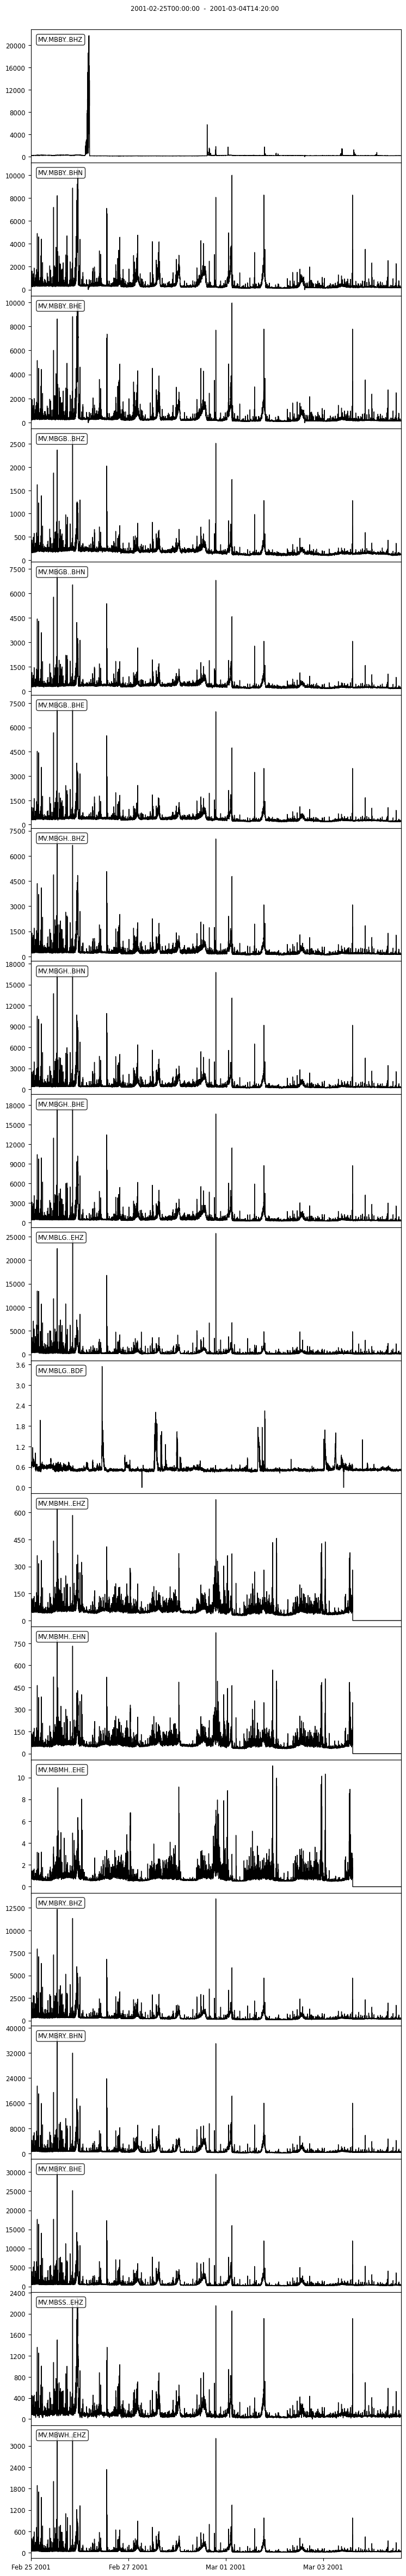

In [2]:
rsamMV = FLOVO.readRSAMfile(startTime, endTime, trace_ids=None, RSAM_TOP=RSAM_DIR)
print(rsamMV)
rsamMV.plot(kind='stream', metrics=['median'])

### 2.1 How to compute RSAM data (simple, slow way)

In this example, we:
- load 10 minutes of seismic data into an ObsPy Trace
- detrend the data vector (a numpy array)
- take the modulus/absolute of the data vector
- compute the mean (average) in each 1-minute window

In [ ]:
import numpy as np
import obspy
tr = obspy.core.read('rsam_example.mseed','mseed')[0]
tr.plot();

# Remove trend
tr.detrend('linear') # and/or a high-pass filter
tr.plot();

# Amplitude is ALWAYS a positive number - use numpy.absolute
tr.data = np.absolute(tr.data)
tr.plot();

def compute_rsam(tr, time_window=60):
    stime = tr.stats.starttime
    duration = int(tr.times()[-1])
    for t in range(0, duration, time_window):
        tr1min = tr.copy().trim(starttime = stime + t, endtime = stime + t + time_window)
        print(f"{stime+t}, {np.mean(tr1min.data)}")

compute_rsam(tr)

In [ ]:
# add frequency index to RSAMmetrics
# add a 1/rsam plot for FFM
# add a way to compute RSAM for overlapping time bins - easy to do if say select 1 minute first, and then apply say a 10-point moving point filter